# Imports

## Libraries

In [1]:
from collections import OrderedDict
import os
import random

from matplotlib import colors

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Import Utility Functions 

Importing from [utils.py](files/utils.py).

In [2]:
from utils import *

## Import Image Processing Functions

Importing from [image_processing.py](files/image_processing.py).

In [3]:
from image_processing import *

# Load Frames

## Load all frames

In [4]:
folders = ["front(20201112_140127)"] # os.listdir(dataset)

# folder_frame_map: Dict of folders -> Dict of frames -> (RGB, D-RGB, ndarray)
folder_frame_map = OrderedDict()

for folder in folders:
    files = os.listdir(folder)
    
    rgb_im_files = []
    depth_arr_files = []
    depth_im_files = []
    timestamps = []
    
    # Filter files wrt their extension
    for file in files:
        if file.endswith("rgb.png"):
            rgb_im_files.append(file)
        elif file.endswith("depth.npy"):
            depth_arr_files.append(file)
        elif file.endswith("depth.png"):
            depth_im_files.append(file)
        elif file.endswith(".json"):
            timestamps.append(file)
        elif file.endswith("edge_vis.png"):
            pass
        elif file.endswith("edge_pts.npy"):
            pass
        else:
            raise AssertionError(f"Unrecognized file: {file}")
            
    rgb_im_files = sorted(rgb_im_files, key=lambda f: int(f.split("_")[0]))
    depth_arr_files = sorted(depth_arr_files, key=lambda f: int(f.split("_")[0]))
    depth_im_files = sorted(depth_im_files, key=lambda f: int(f.split("_")[0]))
    folder_frame_map[folder] = list(zip(rgb_im_files, depth_arr_files, depth_im_files))
    
print("Number of folders:", len(folder_frame_map))
for i, k in enumerate(folders):
    print("{}) Loaded {} frames from {}".format(i+1, len(folder_frame_map[folder]), k))

Number of folders: 1
1) Loaded 2829 frames from front(20201112_140127)


## Visualize frames

In [ ]:
# max_frames = 10
# folder = folders[0]
# num_frames = len(folder_frame_map[folder])
# show_frames = num_frames if num_frames < max_frames else max_frames
# for i in range(show_frames):
#     rgb_img, depth_img, depth_arr = folder_frame_map[folder][i]
#     show_image_pairs(rgb_img, depth_img)

# Detect Corners & Edge

In [ ]:
front_config = {
    "out": "out",
    "size": 30,
    "position": 1,
    "start_depth": 1.0,  # Given in depth-scale
    "contour_width": 25, # Given in y-scale
    "y_step": 5,         # Given in y-scale
    "n_contours": 1000,
    "dynamic_width": True,
    "ransac_thresh": 15,
    "score_thresh": None,
    "roi": [None,None,250,None], # min_y:max_y, min_x:max_x
    "fit_type": "curve",
    "verbose": 0
}

back_config = {
    "out": None,
    "size": 30,
    "position": 2,
    "start_depth": 1.10,  # Given in depth-scale
    "contour_width": 25, # Given in y-scale
    "y_step": 5,         # Given in y-scale
    "n_contours": 1000,
    "dynamic_width": True,
    "ransac_thresh": 10,
    "score_thresh": None,
    "roi": [None,None,250,450], # min_y:max_y, min_x:max_x
    "fit_type": "curve",
    "verbose": 4
}

In [ ]:
def prepare_corner_plot(depth_img, inliers, outliers, edge_pixels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(depth_img)
    if edge_pixels is not None:
        plt.plot(edge_pixels[:,1], edge_pixels[:,0], color="cyan", linewidth=2)
    inlier_pts = plt.scatter(inliers[:,1], inliers[:,0], color="black", marker="o")
    outlier_pts = plt.scatter(outliers[:,1], outliers[:,0], color="purple", marker="^")
    plt.legend((inlier_pts, outlier_pts), ("inliers", "outliers"), loc=1)
    
def prepare_overlay_plot(image, edge_pixels, cstr="cyan"):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.plot(edge_pixels[:,1], edge_pixels[:,0], color=cstr, linewidth=2)

def execute(frame_idx, depth_arr, rgb_img, depth_img, 
            out,
            size,
            position,
            start_depth,
            contour_width,
            y_step,
            n_contours,
            dynamic_width,
            ransac_thresh,
            score_thresh,
            roi,
            fit_type,
            verbose):
    
    # Create a template to find corners
    template = create_template(size=size, position=position)
    
    # Fit a curve (2nd degree polynomial) to inlier detections
    edge_pixels, inliers, outliers = apply_template_matching(depth_arr,
                                         template,
                                         start_depth=start_depth,     # Given in depth-scale
                                         contour_width=contour_width, # Given in y-scale
                                         y_step=y_step,               # Given in y-scale
                                         n_contours=n_contours,
                                         dynamic_width=dynamic_width,
                                         ransac_thresh=ransac_thresh,
                                         score_thresh=score_thresh,
                                         roi=roi,
                                         fit_type=fit_type,
                                         verbose=verbose)
    
    # Store pixel coordinates for the edge
    if out is not None:
        np.save(f"{out}/{frame_idx}_edge_pts.npy", edge_pixels)
      
    # Visualize or store inlier and outlier corners and fitted curve
    prepare_corner_plot(depth_img, inliers, outliers, edge_pixels)
    if out is None:
        plt.show()
    else:
        plt.savefig(f"{out}/{frame_idx}_edge_vis.png")
        plt.close()

    # Visualize or store the mask overlay on original RGB
    prepare_overlay_plot(rgb_img, edge_pixels)
    if out is None:
        plt.show()
    else:
        plt.savefig(f"{out}/rgb_overlay_{frame_idx}.png")
        plt.close()

## Execute on all frames available

In [ ]:
folder = folders[0]
num_frames = len(folder_frame_map[folder])
x = list(range(num_frames))
x = x[2853:]
for i in x:
    rgb_im_file, depth_arr_file, depth_im_file = folder_frame_map[folder][i]
    frame_idx = rgb_im_file.split("_")[0]
    print(f"Detection on frame-{frame_idx}:")
    
    rgb_im_path = os.path.join(folder, rgb_im_file)
    depth_im_path = os.path.join(folder, depth_im_file)
    depth_arr_path = os.path.join(folder, depth_arr_file)

    rgb_img = cv2.imread(rgb_im_path, cv2.IMREAD_COLOR)     # BGR image
    depth_img = cv2.imread(depth_im_path, cv2.IMREAD_COLOR) # BGR image
    depth_arr = np.load(depth_arr_path)
    
    execute(frame_idx, depth_arr, rgb_img, depth_img, **back_config)
    print()

## Pick one frame and execute

In [ ]:
# folder_indices = list(range(8))
# folder_idx = random.choice(folder_indices)
# print("Folder choice:", folder_idx)
folder_idx = 0
folder = folders[folder_idx]

file_indices = list(range(len(folder_frame_map[folder])))
i = random.choice(file_indices)
print("Frame choice:", i)
# i = 10

print("Fetching frame: {} from folder: {}".format(i, folder))

rgb_im_file, depth_arr_file, depth_im_file = folder_frame_map[folder][i]
frame_idx = rgb_im_file.split("_")[0]
print(f"Detection on frame-{frame_idx}:")

rgb_im_path = os.path.join(folder, rgb_im_file)
depth_im_path = os.path.join(folder, depth_im_file)
depth_arr_path = os.path.join(folder, depth_arr_file)

rgb_img = cv2.imread(rgb_im_path, cv2.IMREAD_COLOR)     # BGR image
depth_img = cv2.imread(depth_im_path, cv2.IMREAD_COLOR) # BGR image
depth_arr = np.load(depth_arr_path)

execute(frame_idx, depth_arr, rgb_img, depth_img, **back_config)

# TODO: Generate Video

<Figure size 432x288 with 0 Axes>

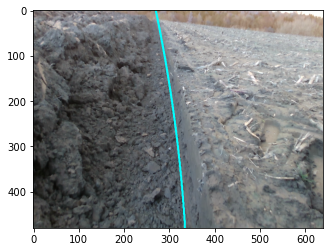

In [7]:
from matplotlib.animation import FFMpegWriter

plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'

folder = "front(20201112_140127)"
fig = plt.figure()
cut = folder_frame_map[folder][150:450]

# Fixing random state for reproducibility
metadata = dict(title='Detection Demo')
writer = FFMpegWriter(fps=30, metadata=metadata)

fig = plt.figure()
imgh = plt.imshow(np.zeros((480, 640), dtype=np.uint8))
ph, = plt.plot([], [], color="cyan", linewidth=2)

with writer.saving(fig, "Detection Demo.mp4", 100):
    for rgb_im_file, depth_arr_file, depth_im_file in cut:
        frame_idx = rgb_im_file.split("_")[0]

        rgb_im_path = os.path.join(folder, rgb_im_file)
        rgb_img = cv2.imread(rgb_im_path, cv2.IMREAD_COLOR)
        edge_pixels = np.load(os.path.join(folder, f"{frame_idx}_edge_pts.npy"))
        
        imgh.set_data(rgb_img)
        ph.set_data(edge_pixels[:,1], edge_pixels[:,0])
        
        writer.grab_frame()